# J3-PM — PyTorch : MLP vs CNN sur MNIST

**Objectif :** comparer un MLP et un CNN de taille similaire (~100K paramètres) pour montrer l'apport de la convolution à budget constant.

| Modèle | Architecture | Params |
|--------|-------------|--------|
| MLP | 784 → 128 → 64 → 10 | ~109 K |
| CNN | Conv(16)+Pool → Conv(32)+Pool → FC(64) → 10 | ~106 K |


In [1]:
from __future__ import annotations

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
# ROCm/HIP plante sur Conv2d -- on force CPU
DEVICE = torch.device('cpu')
print(f'Device : {DEVICE}')


Device : cpu


## 1. Chargement de MNIST

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_ds = datasets.MNIST('./data', train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=4)

print(f'Train : {len(train_ds):,} exemples  |  Test : {len(test_ds):,} exemples')
print(f'Shape : {train_ds[0][0].shape}  dtype : {train_ds[0][0].dtype}')


Train : 60,000 exemples  |  Test : 10,000 exemples
Shape : torch.Size([1, 28, 28])  dtype : torch.float32


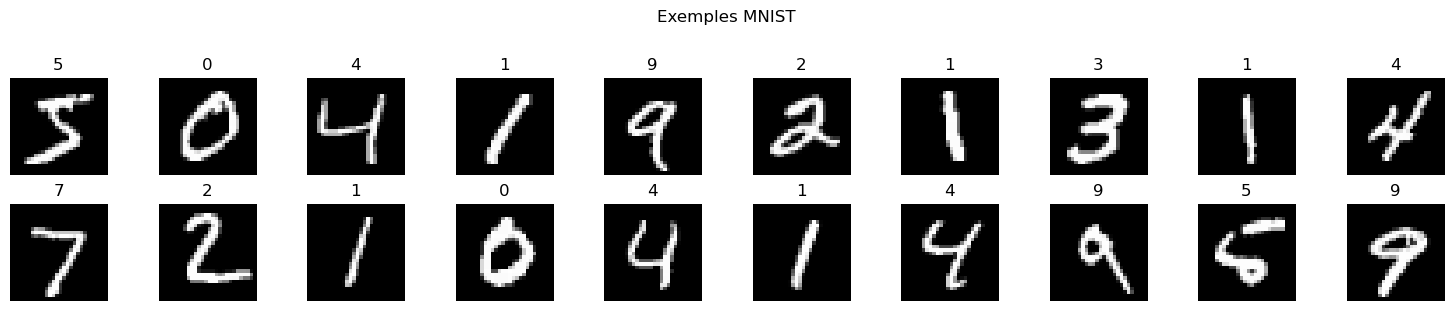

In [3]:
# Grille 2×10 : train (haut) / test (bas)
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    for row, ds in enumerate([train_ds, test_ds]):
        img, label = ds[i]
        axes[row, i].imshow(img.squeeze(), cmap='gray')
        axes[row, i].set_title(label)
        axes[row, i].axis('off')
axes[0, 0].set_ylabel('train', fontsize=9)
axes[1, 0].set_ylabel('test',  fontsize=9)
plt.suptitle('Exemples MNIST', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


## 2. Architecture des modèles

Budget similaire (~100K paramètres) pour une comparaison équitable.


In [4]:
class MLP(nn.Module):
    """MLP : 784 -> 128 -> 64 -> 10  (~109 K paramètres)"""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)     # Flatten [B,1,28,28] -> [B,784]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)             # logits [B,10]


class CNN(nn.Module):
    """CNN : Conv(16)+Pool -> Conv(32)+Pool -> FC(64) -> 10  (~106 K paramètres)"""

    def __init__(self) -> None:
        super().__init__()
        # Extraction
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, padding=1)  # [B,16,28,28]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # [B,32,14,14]
        self.pool  = nn.MaxPool2d(2)                               # /2 à chaque fois
        # Classification
        self.fc1 = nn.Linear(32 * 7 * 7, 64)                      # 1568 -> 64
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))  # [B,16,14,14]
        x = self.pool(F.relu(self.conv2(x)))  # [B,32,7,7]
        x = x.view(x.size(0), -1)             # [B,1568]
        x = F.relu(self.fc1(x))
        return self.fc2(x)                    # logits [B,10]


In [5]:
def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())


mlp = MLP().to(DEVICE)
cnn = CNN().to(DEVICE)

n_mlp, n_cnn = count_params(mlp), count_params(cnn)
print(f'MLP : {n_mlp:,} paramètres')
print(f'CNN : {n_cnn:,} paramètres')
print(f'Ratio CNN/MLP : {n_cnn / n_mlp:.3f}')


MLP : 109,386 paramètres
CNN : 105,866 paramètres
Ratio CNN/MLP : 0.968


## 3. Entraînement

In [6]:
def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
) -> float:
    """Retourne la loss moyenne (train)."""
    model.train()
    total = 0.0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
        total += loss.item() * len(y)
    return total / len(loader.dataset)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """Retourne l'accuracy sur loader."""
    model.eval()
    correct = 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        correct += (model(X).argmax(1) == y).sum().item()
    return correct / len(loader.dataset)


In [7]:
N_EPOCHS  = 10
criterion = nn.CrossEntropyLoss()
opt_mlp   = optim.Adam(mlp.parameters(), lr=1e-3)
opt_cnn   = optim.Adam(cnn.parameters(), lr=1e-3)

history: dict[str, list[float]] = {
    'mlp_loss': [], 'cnn_loss': [],
    'mlp_acc':  [], 'cnn_acc':  [],
}

print(f'{"Epoch":>5}  {"MLP loss":>10}  {"MLP acc":>9}  {"CNN loss":>10}  {"CNN acc":>9}')
print('-' * 55)
for epoch in range(1, N_EPOCHS + 1):
    l_mlp = train_epoch(mlp, train_loader, opt_mlp, criterion)
    l_cnn = train_epoch(cnn, train_loader, opt_cnn, criterion)
    a_mlp = evaluate(mlp, test_loader)
    a_cnn = evaluate(cnn, test_loader)

    history['mlp_loss'].append(l_mlp)
    history['cnn_loss'].append(l_cnn)
    history['mlp_acc'].append(a_mlp)
    history['cnn_acc'].append(a_cnn)

    print(f'{epoch:5d}  {l_mlp:10.4f}  {a_mlp*100:8.2f}%  {l_cnn:10.4f}  {a_cnn*100:8.2f}%')


Epoch    MLP loss    MLP acc    CNN loss    CNN acc
-------------------------------------------------------


    1      0.3966     94.47%      0.3130     97.34%


    2      0.1641     96.03%      0.0768     98.06%


    3      0.1144     96.66%      0.0560     98.32%


    4      0.0883     97.13%      0.0432     98.62%


    5      0.0693     97.18%      0.0354     98.71%


    6      0.0576     97.63%      0.0306     98.92%


    7      0.0460     97.60%      0.0266     98.80%


    8      0.0376     97.70%      0.0231     98.85%


    9      0.0324     97.56%      0.0185     98.91%


   10      0.0276     97.66%      0.0158     98.92%


## 4. Résultats

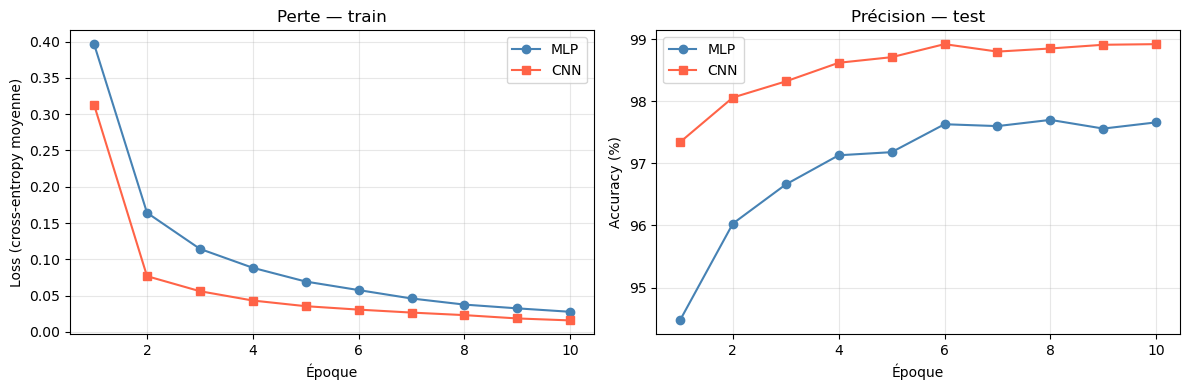

Résultats finaux (epoch 10) :
  MLP : 97.66%
  CNN : 98.92%
  Ecart : +1.26 pp pour le CNN


In [8]:
epochs = range(1, N_EPOCHS + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(epochs, history['mlp_loss'], 'o-', label='MLP', color='steelblue')
ax1.plot(epochs, history['cnn_loss'], 's-', label='CNN', color='tomato')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Loss (cross-entropy moyenne)')
ax1.set_title('Perte — train')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, [a * 100 for a in history['mlp_acc']], 'o-', label='MLP', color='steelblue')
ax2.plot(epochs, [a * 100 for a in history['cnn_acc']], 's-', label='CNN', color='tomato')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Précision — test')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Résultats finaux (epoch {N_EPOCHS}) :')
print(f'  MLP : {history["mlp_acc"][-1] * 100:.2f}%')
print(f'  CNN : {history["cnn_acc"][-1] * 100:.2f}%')
print(f'  Ecart : +{(history["cnn_acc"][-1] - history["mlp_acc"][-1]) * 100:.2f} pp pour le CNN')


## 5. Erreurs MLP corrigées par le CNN

Exemples **mal classés par le MLP** mais **bien classés par le CNN**.


In [9]:
@torch.no_grad()
def get_preds(
    model: nn.Module, loader: DataLoader
) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    preds, labels = [], []
    for X, y in loader:
        X = X.to(DEVICE)
        preds.append(model(X).argmax(1).cpu())
        labels.append(y)
    return torch.cat(preds), torch.cat(labels)


preds_mlp, true_labels = get_preds(mlp, test_loader)
preds_cnn, _           = get_preds(cnn, test_loader)

mlp_wrong = preds_mlp != true_labels
cnn_right  = preds_cnn == true_labels
rescued    = torch.where(mlp_wrong & cnn_right)[0]

print(f'Erreurs MLP  : {mlp_wrong.sum().item()}')
print(f'Erreurs CNN  : {(preds_cnn != true_labels).sum().item()}')
print(f'Rescues CNN  : {len(rescued)}')


Erreurs MLP  : 234
Erreurs CNN  : 108
Rescues CNN  : 174


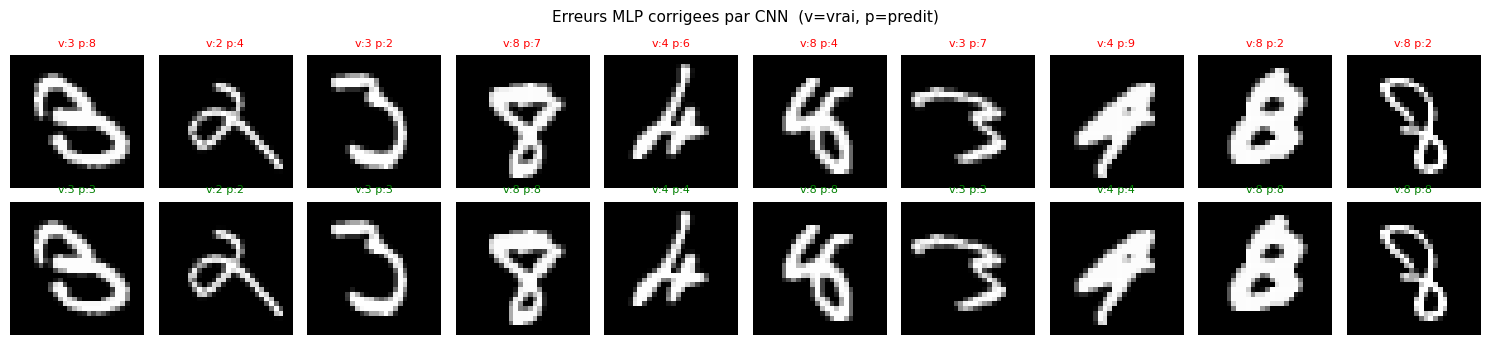

In [10]:
fig, axes = plt.subplots(2, 10, figsize=(15, 3.5))
for col, idx in enumerate(rescued[:10]):
    i = idx.item()
    img        = test_ds[i][0].squeeze().numpy()
    true_lbl   = true_labels[i].item()
    wrong_lbl  = preds_mlp[i].item()
    right_lbl  = preds_cnn[i].item()

    axes[0, col].imshow(img, cmap='gray')
    axes[0, col].set_title(f'v:{true_lbl} p:{wrong_lbl}', fontsize=8, color='red')
    axes[0, col].axis('off')

    axes[1, col].imshow(img, cmap='gray')
    axes[1, col].set_title(f'v:{true_lbl} p:{right_lbl}', fontsize=8, color='green')
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('MLP ✗', fontsize=10, color='red')
axes[1, 0].set_ylabel('CNN ✓', fontsize=10, color='green')
plt.suptitle('Erreurs MLP corrigees par CNN  (v=vrai, p=predit)', fontsize=11)
plt.tight_layout()
plt.show()


## 6. Analyse

**Pourquoi le CNN fait mieux avec le même budget ?**

1. **Biais inductif spatial** : les convolutions exploitent la *localité* — deux pixels voisins sont traités par le même filtre.
2. **Partage des poids** : un filtre 3×3 (9 valeurs) couvre toute l'image. Le MLP doit apprendre des connexions redondantes pour chaque position.
3. **Invariance par translation** : le max-pooling rend le réseau robuste aux petits décalages — ce que ne sait pas faire le MLP.

> Sur CIFAR-10 ou ImageNet, l'écart entre MLP et CNN est bien plus marqué.
